<a href="https://colab.research.google.com/github/llsilvacarlos/Cybersec-Labs/blob/main/Lab07_vulnerability_classification_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vulnerability Classification with Natural Language Processing

So far, we have been classifying vulnerabilities using features like the ones used to compute CVSS. In this lab, you will learn how to apply Natural Language Processing (NLP) techniques to extract features from texts. One can apply such methods, for instance, to process textual fields like the vulnerability description.

## Preprocessing techniques

We will see in this lab that we often use machine learning models to solve natural language processing problems. However, as we saw in the previous labs, machine learning models expect numbers as input, so we first need to convert our texts to numbers. Ideally, before jumping to that task, we should make sure that our texts are consistent in terms of symbols, punctuation, and so on. Let's take a look at how to do that.

### Cleaning & normalization

Text data can be messy sometimes. People can type special characters, use inconsistent punctuation symbols, emojis, or even symbols that are only present in non-English languages. As a concrete example, take a look at the following comparison. Why is the result `False`?

In [ ]:
print("it‘s ok" == "it’s ok")


False


## Lab: classifying vulnerabilities severity

Now it's your turn. You should train a classifier to predict vulnerabilities severities based on their description. Let's start by downloading and exploring another dataset.

Important! Before you get started, create a copy of this notebook to your google drive and work on your own copy.

Once you are done, submit your solutions here: [https://forms.gle/i1wetqnyoh1vHLRi6](https://forms.gle/i1wetqnyoh1vHLRi6).

The following dataset was built off of the National Vulnerability Database (NVD). It contains several CVE records from 2016 to 2020. Each CVE has a vulnerability description, a severity (based on CVSS 3), a field indicating whether it has an exploit listed on Exploit-DB, and a list of Exploit IDs when the last condition is true.

In [21]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

tfds.disable_progress_bar()


In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1ZHVmHh1KWYeiYEHQhOwDJQ1tC93a-n6a' -O '211ds.csv' -q
df = pd.read_csv('211ds.csv', names=['cve_id', 'description', 'severity', 'has_exploit', 'exploit_ids'])
df

,cve_id,description,severity,has_exploit,exploit_ids
0,CVE-2016-0002,The Microsoft (1) VBScript 5.7 and 5.8 and (2)...,HIGH,0,NaN
1,CVE-2016-0003,Microsoft Edge allows remote attackers to exec...,CRITICAL,0,NaN
2,CVE-2016-0005,Microsoft Internet Explorer 9 through 11 allow...,MEDIUM,0,NaN
3,CVE-2016-0006,The sandbox implementation in Microsoft Window...,HIGH,1,39311
4,CVE-2016-0007,The sandbox implementation in Microsoft Window...,HIGH,1,"39310,39311"
...,...,...,...,...,...
71345,CVE-2020-9994,A path handling issue was addressed with impro...,HIGH,0,NaN
71346,CVE-2020-9995,An issue existed in the parsing of URLs. This ...,MEDIUM,0,NaN
71347,CVE-2020-9996,A use after free issue was addressed with impr...,HIGH,0,NaN
71348,CVE-2020-9997,An information disclosure issue was addressed ...,MEDIUM,0,NaN


In [ ]:
severities = {
    'LOW': 0,
    'MEDIUM': 0,
    'HIGH': 1,
    'CRITICAL': 1,
}
df['severity'] = df['severity'].apply(lambda x: severities[x])
df

,cve_id,description,severity,has_exploit,exploit_ids
0,CVE-2016-0002,The Microsoft (1) VBScript 5.7 and 5.8 and (2)...,1,0,NaN
1,CVE-2016-0003,Microsoft Edge allows remote attackers to exec...,1,0,NaN
2,CVE-2016-0005,Microsoft Internet Explorer 9 through 11 allow...,0,0,NaN
3,CVE-2016-0006,The sandbox implementation in Microsoft Window...,1,1,39311
4,CVE-2016-0007,The sandbox implementation in Microsoft Window...,1,1,"39310,39311"
...,...,...,...,...,...
71345,CVE-2020-9994,A path handling issue was addressed with impro...,1,0,NaN
71346,CVE-2020-9995,An issue existed in the parsing of URLs. This ...,0,0,NaN
71347,CVE-2020-9996,A use after free issue was addressed with impr...,1,0,NaN
71348,CVE-2020-9997,An information disclosure issue was addressed ...,0,0,NaN


In [ ]:
import tensorflow as tf
df['description'] = df['description'].apply(lambda x: ' '.join(tf.keras.preprocessing.text.text_to_word_sequence(x)))
df

,cve_id,description,severity,has_exploit,exploit_ids
0,CVE-2016-0002,the microsoft 1 vbscript 5 7 and 5 8 and 2 jsc...,1,0,NaN
1,CVE-2016-0003,microsoft edge allows remote attackers to exec...,1,0,NaN
2,CVE-2016-0005,microsoft internet explorer 9 through 11 allow...,0,0,NaN
3,CVE-2016-0006,the sandbox implementation in microsoft window...,1,1,39311
4,CVE-2016-0007,the sandbox implementation in microsoft window...,1,1,"39310,39311"
...,...,...,...,...,...
71345,CVE-2020-9994,a path handling issue was addressed with impro...,1,0,NaN
71346,CVE-2020-9995,an issue existed in the parsing of urls this i...,0,0,NaN
71347,CVE-2020-9996,a use after free issue was addressed with impr...,1,0,NaN
71348,CVE-2020-9997,an information disclosure issue was addressed ...,0,0,NaN


In [ ]:
RANDOM_STATE = 42
train_df, val_df, test_df = \
  np.split(df.sample(frac=1, random_state=RANDOM_STATE),
                       [int(.70*len(df)), int(.85*len(df))])

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(train_df['description'].values, tf.string),
        tf.cast(train_df['severity'].values, tf.int64),
    )
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(val_df['description'].values, tf.string),
        tf.cast(val_df['severity'].values, tf.int64),
    )
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(test_df['description'].values, tf.string),
        tf.cast(test_df['severity'].values, tf.int64),
    )
)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
VOCAB_SIZE = 50000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
dataframes = {
    'train': train_df,
    'val': val_df,
    'test': test_df,
}

severities = {
    'LOW': 0,
    'MEDIUM': 0,
    'HIGH': 1,
    'CRITICAL': 1,
}

Now you are ready to train your model. First, you will need to define a model as we did for the sentiment classification example. Then, you should call the .fit method to train your model with the dataset we just defined above.

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/10
781/781 [==============================] - 34s 31ms/step - loss: 0.5067 - accuracy: 0.7018 - val_loss: 0.4133 - val_accuracy: 0.8026
Epoch 2/10
781/781 [==============================] - 22s 29ms/step - loss: 0.3504 - accuracy: 0.8386 - val_loss: 0.3996 - val_accuracy: 0.8188
Epoch 3/10
781/781 [==============================] - 30s 39ms/step - loss: 0.2988 - accuracy: 0.8681 - val_loss: 0.3988 - val_accuracy: 0.7917
Epoch 4/10
781/781 [==============================] - 22s 28ms/step - loss: 0.2589 - accuracy: 0.8901 - val_loss: 0.4138 - val_accuracy: 0.8146
Epoch 5/10
781/781 [==============================] - 22s 28ms/step - loss: 0.2256 - accuracy: 0.9079 - val_loss: 0.4528 - val_accuracy: 0.8203
Epoch 6/10
781/781 [==============================] - 22s 28ms/step - loss: 0.1993 - accuracy: 0.9202 - val_loss: 0.4683 - val_accuracy: 0.8161
Epoch 7/10
781/781 [==============================] - 22s 28ms/step - loss: 0.1773 - accuracy: 0.9297 - val_loss: 0.4801 - val_accuracy:

After training your model, use the `test` split to calculate and print your model's accuracy.

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

168/168 [==============================] - 3s 16ms/step - loss: 0.5938 - accuracy: 0.8177
Test Loss: 0.5937585830688477
Test Accuracy: 0.8177146315574646


Finally, plot a graph to compare the accuracy and loss values over the epochs.

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6327798433601857)

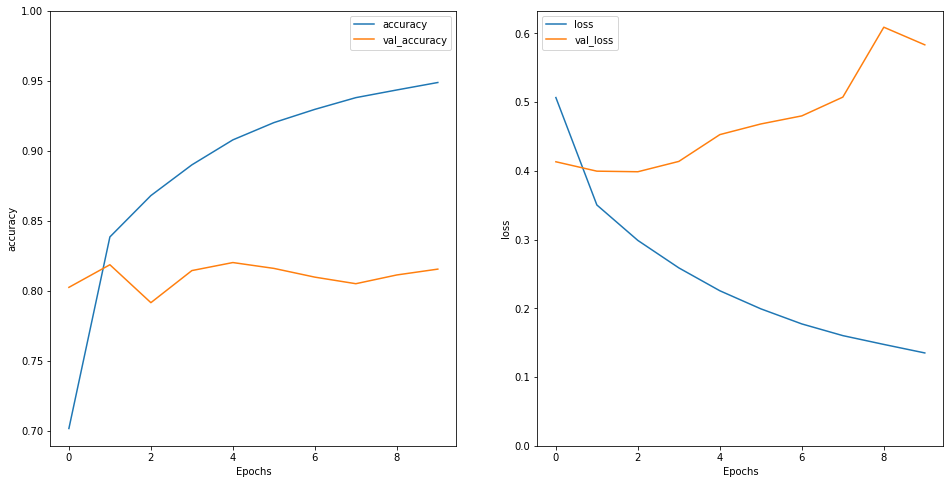

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)